In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = "cover"
print(target)

display(train[target].head(3))

cover


0    0.050
1    0.725
2    0.025
Name: cover, dtype: float64

In [9]:
train_missing_40 = train_missing[train_missing.percent<0.4].index
test_missing_40 =  test_missing[test_missing.percent<0.4].index
train_missing_15 = train_missing[train_missing.percent<0.15].index
test_missing_15 =  test_missing[test_missing.percent<0.15].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features_40 = set(train_missing_40) & set(test_missing_40)
features_15 = set(train_missing_15) & set(test_missing_15)
features = set(features_40) - set(categorical_features)
knn_features = set(features) - set(features_15)  

In [10]:
len(features), len(knn_features)

(2259, 512)

In [11]:
land_sat_feats = []
for years in list(range(2000,2021)):
  n_f = [col for col in features if str(years) in col]
  land_sat_feats += n_f
features = [col for col in features if col not in land_sat_feats]
knn_features = [col for col in knn_features if col not in land_sat_feats]

In [12]:
len(features), len(knn_features)

(309, 62)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

missing_train = train.fillna(9999)
missing_test = test.fillna(9999)

for mcol in tqdm(knn_features):
    knn_mtrain = missing_train.loc[missing_train[mcol]==9999]
    knn_train = missing_train.loc[missing_train[mcol]!=9999]
    knn_mtest = missing_test.loc[missing_test[mcol]==9999]

    features.remove(mcol)

    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(knn_train[features],knn_train[mcol])
    knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
    knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])

    train = train.merge(knn_mtrain[["id",f"knn_{mcol}"]],how="left",on="id")
    train[mcol] = train[mcol].fillna(0)
    train[f"knn_{mcol}"] = train[f"knn_{mcol}"].fillna(0)
    train[mcol] = train[mcol] + train[f"knn_{mcol}"]

    test = test.merge(knn_mtest[["id",f"knn_{mcol}"]],how="left",on="id")
    test[mcol] = test[mcol].fillna(0)
    test[f"knn_{mcol}"] = test[f"knn_{mcol}"].fillna(0)
    test[mcol] = test[mcol] + test[f"knn_{mcol}"]

    features.append(mcol)

display(train[knn_features].head(10))
display(test[knn_features].head(10))

  0%|          | 0/62 [00:00<?, ?it/s]<ipython-input-13-532bdd304887>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtrain[f"knn_{mcol}"] = knn.predict(knn_mtrain[features])
<ipython-input-13-532bdd304887>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  knn_mtest[f"knn_{mcol}"] = knn.predict(knn_mtest[features])
  2%|▏         | 1/62 [00:03<03:37,  3.56s/it]<ipython-input-13-532bdd304887>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,NLI,SLAVI,DVIMSS,IR550,MCARI1,Ferric_Oxides,VARIgreen,SAVI,PPR,NIR,...,H,Red,Chlred_edge,GARI,BWDRVI,GEMI,SWIR2,MCARI2,NDWI,mCRIRE
0,0.243821,55.834898,-1.499917,0.040873,7.768361,0.061078,-1.569704,-0.676338,-0.290628,4.496400,...,1.536542,12.291277,2.733582,-0.234759,-0.980000,-65.107007,0.126413,1.024100,0.689504,-0.264809
1,0.979600,3658.334622,117.831956,0.013727,61.967369,0.090641,0.464793,0.238271,-0.026466,70.342323,...,1.410671,50.989620,0.724878,-0.823061,-0.832205,-351.833930,1.017969,0.552047,0.017501,-0.463735
2,0.535998,145.440316,0.291149,0.028836,9.920009,0.081935,7.850269,-0.596540,-0.191400,7.821566,...,1.532755,18.480610,2.362776,-0.096821,-0.969846,-120.471556,0.114172,0.782590,0.631929,-0.270155
3,0.848795,868.810277,26.308228,0.021359,7.866391,0.088156,0.577517,-0.263694,-0.104662,25.018325,...,1.495565,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630
4,0.337366,44.545636,0.818969,0.032890,24.114712,0.047640,-1.148279,-0.548395,-0.313422,4.474403,...,1.554811,9.919600,2.216966,-0.300833,-0.984732,-32.365638,0.036060,3.224675,0.743429,-0.374138
5,0.848795,868.810277,26.308228,0.021359,7.866391,0.088156,0.577517,-0.263694,-0.104662,25.018325,...,1.495565,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630
6,0.465244,96.938546,0.375503,0.033065,11.351343,0.080216,-3.105288,-0.588467,-0.247777,6.415680,...,1.540411,15.022129,2.341471,-0.191909,-0.974746,-79.293798,0.087500,1.082886,0.649978,-0.299195
7,0.169172,101.353342,-6.792398,0.018070,35.933363,0.127199,-50.824985,-0.844921,-0.153107,5.211494,...,1.554245,19.299984,3.703350,-0.055762,-0.986262,-206.976268,0.148056,4.088720,0.827863,-0.200860
8,0.568627,142.997158,1.576855,0.025985,18.619661,0.105604,-3.133206,-0.552662,-0.239956,8.011537,...,1.551772,17.650833,2.203177,-0.193910,-0.974801,-99.085508,0.198072,1.437299,0.655387,-0.326286
9,0.346556,57.407128,0.116010,0.038088,13.099381,0.094146,-1.695201,-0.593507,-0.278412,4.896877,...,1.540390,11.636496,2.376309,-0.240419,-0.979164,-49.117164,0.086716,1.608101,0.685610,-0.315544


,NLI,SLAVI,DVIMSS,IR550,MCARI1,Ferric_Oxides,VARIgreen,SAVI,PPR,NIR,...,H,Red,Chlred_edge,GARI,BWDRVI,GEMI,SWIR2,MCARI2,NDWI,mCRIRE
0,0.848795,868.810277,26.308228,0.021359,7.866391,0.088156,0.577517,-0.263694,-0.104662,25.018325,...,1.495565,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630
1,0.658823,136.242456,5.478744,0.030744,22.162411,0.100038,-5.670812,-0.398572,-0.232446,8.606872,...,1.544322,15.177749,1.749661,-0.220478,-0.969327,-50.269846,0.203959,1.556746,0.597267,-0.418280
2,0.883218,905.070874,28.968576,0.021419,9.178399,0.086700,0.577090,-0.215043,-0.107223,26.142190,...,1.497484,33.772681,1.390758,-0.099560,-0.914342,-90.264924,0.365417,0.190044,0.295492,-0.316523
3,0.211141,47.185164,-1.301446,0.034843,16.880606,0.068374,-1.144489,-0.670245,-0.315875,4.164535,...,1.552029,11.296329,2.712507,-0.283029,-0.985025,-54.702543,0.033908,2.383858,0.746567,-0.293223
4,0.147521,138.114280,-10.455337,0.023751,1.485439,0.084139,1.912993,-0.911583,-0.148981,5.699820,...,1.529995,24.134905,4.234328,0.053439,-0.980145,-351.078729,0.096436,0.154940,0.761533,-0.135897
5,0.843519,836.785779,26.774289,0.022092,9.650818,0.085772,0.701280,-0.252810,-0.115641,24.570061,...,1.503037,32.193857,1.514408,-0.111991,-0.919191,-89.876426,0.337050,0.219221,0.326208,-0.313834
6,0.435992,70.906138,1.044402,0.034199,16.267716,0.053720,-1.548610,-0.551599,-0.284961,5.638958,...,1.547764,12.489099,2.214788,-0.258502,-0.978765,-50.800409,0.085234,1.756099,0.676659,-0.344197
7,0.260737,73.906687,-2.648215,0.026830,21.418659,0.126179,-2.842335,-0.718348,-0.232666,4.996790,...,1.550916,14.640511,2.929983,-0.167193,-0.983447,-98.665395,0.150323,2.558447,0.763572,-0.257846
8,0.455053,72.460664,1.367738,0.035531,14.739343,0.085077,-2.438843,-0.536900,-0.251481,5.775920,...,1.538688,12.494470,2.163200,-0.214173,-0.975749,-48.937543,0.050833,1.556755,0.659443,-0.339532
9,0.848795,868.810277,26.308228,0.021359,7.866391,0.088156,0.577517,-0.263694,-0.104662,25.018325,...,1.495565,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630


## Model

In [14]:
#!pip install iterative-stratification

In [15]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold, TimeSeriesSplit
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [16]:
class CFG:
  ver=77
  model="lightgbm"
  n_folds=15
  trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
  seed=42
  boosting_type="gbdt"

In [17]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df):
  Fold = TimeSeriesSplit(n_splits=CFG.n_folds)
  for n, (train_index, val_index) in enumerate(Fold.split(df)):
    df.loc[train_index, f'tr_fold{n}'] = 1
    df.loc[val_index, 'va_fold'] = int(n)
    df[f"tr_fold{n}"] = df[f"tr_fold{n}"].fillna(0)
    df[f'tr_fold{n}'] = df[f'tr_fold{n}'].astype(int)
  df["va_fold"] = df["va_fold"].fillna(999)
  df['va_fold'] = df['va_fold'].astype(int)
  return df

In [18]:
def get_score(labels, preds):
  rmse = np.sqrt(mean_squared_error(labels, preds))
  print(f"RMSE {rmse}")

In [19]:
#features = list(features)
features.remove('id')
#features.remove('area')
features.remove("year")
#features.remove("month")
#features.append("mesh20")

In [20]:
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'boosting': "dart",
        'seed': CFG.seed,
        "reg_alpha":0.1,
        #'reg_lambda': 0.5,
        "n_estimators":5000,
        'min_child_weight': 1,
        'colsample_bytree': 0.4
    }

In [21]:
def get_pred(df, test, params):
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))
  params["n_estimators"] = 5000

  ctg_list = ["year","month","mesh20"]

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train[f'tr_fold{fold}'] == 1]
      valid_folds = train[train['va_fold'] == fold]

      print(f"train period : {str(train_folds.iloc[0].year)}年{str(train_folds.iloc[0].month)}月 ～ {str(train_folds.iloc[-1].year)}年{str(train_folds.iloc[-1].month)}月")
      print(f"valid period : {str(valid_folds.iloc[0].year)}年{str(valid_folds.iloc[0].month)}月 ～ {str(valid_folds.iloc[-1].year)}年{str(valid_folds.iloc[-1].month)}月")


      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target].values
      valid_labels = valid_folds[target].values

      #clf = model
      params["n_estimators"] += 250
      clf = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              #categorical_feature = ctg_list,
              verbose = 1000,
              early_stopping_rounds=50)
      
      valid_folds[f"pred"] = clf.predict(valid_X)
      test_preds[:, fold] = clf.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(clf.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds["pred"])

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target], oof_df[f"pred"])
  return oof_df,  test_preds

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.164157
[2000]	valid_0's rmse: 0.159299
[3000]	valid_0's rmse: 0.156487
[4000]	valid_0's rmse: 0.154515
[5000]	valid_0's rmse: 0.154129


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15415922060379378
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0919036
[2000]	valid_0's rmse: 0.0921245
[3000]	valid_0's rmse: 0.0917597
[4000]	valid_0's rmse: 0.0916786
[5000]	valid_0's rmse: 0.0917247


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09159583147258327
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.14313
[2000]	valid_0's rmse: 0.140738
[3000]	valid_0's rmse: 0.1376
[4000]	valid_0's rmse: 0.136407
[5000]	valid_0's rmse: 0.135141


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13425962551507017
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.122239
[2000]	valid_0's rmse: 0.121495
[3000]	valid_0's rmse: 0.120838
[4000]	valid_0's rmse: 0.120826
[5000]	valid_0's rmse: 0.119384
[6000]	valid_0's rmse: 0.118428


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11842833061798473
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.113911
[2000]	valid_0's rmse: 0.112838
[3000]	valid_0's rmse: 0.112867
[4000]	valid_0's rmse: 0.112882
[5000]	valid_0's rmse: 0.111832
[6000]	valid_0's rmse: 0.1111


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11107425645300723
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.088021
[2000]	valid_0's rmse: 0.0912288
[3000]	valid_0's rmse: 0.0920987
[4000]	valid_0's rmse: 0.0914104
[5000]	valid_0's rmse: 0.0905552
[6000]	valid_0's rmse: 0.0889238


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.08774841723605178
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.175978
[2000]	valid_0's rmse: 0.17581
[3000]	valid_0's rmse: 0.175374
[4000]	valid_0's rmse: 0.175571
[5000]	valid_0's rmse: 0.175645
[6000]	valid_0's rmse: 0.175596


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.17549721238807903
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0585823
[2000]	valid_0's rmse: 0.0584256
[3000]	valid_0's rmse: 0.058168
[4000]	valid_0's rmse: 0.0583508
[5000]	valid_0's rmse: 0.0585691
[6000]	valid_0's rmse: 0.0589205
[7000]	valid_0's rmse: 0.0586841


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.0586841347700283
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.134623
[2000]	valid_0's rmse: 0.135314
[3000]	valid_0's rmse: 0.136479
[4000]	valid_0's rmse: 0.136674
[5000]	valid_0's rmse: 0.135571
[6000]	valid_0's rmse: 0.134616
[7000]	valid_0's rmse: 0.133779


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13353217133669554
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0592901
[2000]	valid_0's rmse: 0.0582619
[3000]	valid_0's rmse: 0.0576707
[4000]	valid_0's rmse: 0.0576433
[5000]	valid_0's rmse: 0.0571859
[6000]	valid_0's rmse: 0.056947
[7000]	valid_0's rmse: 0.0565509


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.056413578287755735
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.253595
[2000]	valid_0's rmse: 0.254356
[3000]	valid_0's rmse: 0.254838
[4000]	valid_0's rmse: 0.25488
[5000]	valid_0's rmse: 0.253094
[6000]	valid_0's rmse: 0.251252
[7000]	valid_0's rmse: 0.25137


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.24961730023827364
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.225709
[2000]	valid_0's rmse: 0.224684
[3000]	valid_0's rmse: 0.223557
[4000]	valid_0's rmse: 0.222837
[5000]	valid_0's rmse: 0.220651
[6000]	valid_0's rmse: 0.218568
[7000]	valid_0's rmse: 0.217075
[8000]	valid_0's rmse: 0.214991


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2149913841188179
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.274645
[2000]	valid_0's rmse: 0.272753
[3000]	valid_0's rmse: 0.273238
[4000]	valid_0's rmse: 0.272864
[5000]	valid_0's rmse: 0.272803
[6000]	valid_0's rmse: 0.272986
[7000]	valid_0's rmse: 0.272486
[8000]	valid_0's rmse: 0.272478


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27249516224913223
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.198443
[2000]	valid_0's rmse: 0.193738
[3000]	valid_0's rmse: 0.192509
[4000]	valid_0's rmse: 0.191643
[5000]	valid_0's rmse: 0.191135
[6000]	valid_0's rmse: 0.190647
[7000]	valid_0's rmse: 0.190842
[8000]	valid_0's rmse: 0.190693


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19062723560412342
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.187714
[2000]	valid_0's rmse: 0.185529
[3000]	valid_0's rmse: 0.187102
[4000]	valid_0's rmse: 0.187855
[5000]	valid_0's rmse: 0.188135
[6000]	valid_0's rmse: 0.187869
[7000]	valid_0's rmse: 0.188065
[8000]	valid_0's rmse: 0.188231


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18824726871249747


,feature,importance
165,lat,0.025840
34,warm_sst,0.020251
148,lon,0.017196
35,MIN_D678_500,0.014520
243,fetch,0.013586
93,river_dist,0.012706
159,hist_warm_sst,0.012088
126,sst_ymd,0.011653
279,Date_Acquired,0.011522
96,MIN_GARI,0.010999


RMSE 0.16208207130588784

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.165788
[2000]	valid_0's rmse: 0.160183
[3000]	valid_0's rmse: 0.157698
[4000]	valid_0's rmse: 0.156142
[5000]	valid_0's rmse: 0.155189


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15492141861088046
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0910444
[2000]	valid_0's rmse: 0.0913171
[3000]	valid_0's rmse: 0.0910798
[4000]	valid_0's rmse: 0.0913748
[5000]	valid_0's rmse: 0.0912747


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09159902267902936
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.141157
[2000]	valid_0's rmse: 0.13805
[3000]	valid_0's rmse: 0.137713
[4000]	valid_0's rmse: 0.137086
[5000]	valid_0's rmse: 0.136042


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1345970480294678
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.120102
[2000]	valid_0's rmse: 0.119097
[3000]	valid_0's rmse: 0.119005
[4000]	valid_0's rmse: 0.118518
[5000]	valid_0's rmse: 0.118621
[6000]	valid_0's rmse: 0.118395


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11839524702895883
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.113196
[2000]	valid_0's rmse: 0.112774
[3000]	valid_0's rmse: 0.114363
[4000]	valid_0's rmse: 0.113712
[5000]	valid_0's rmse: 0.113904
[6000]	valid_0's rmse: 0.113287


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11298275832060585
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0885152
[2000]	valid_0's rmse: 0.0916053
[3000]	valid_0's rmse: 0.0930744
[4000]	valid_0's rmse: 0.0919539
[5000]	valid_0's rmse: 0.0915405
[6000]	valid_0's rmse: 0.0895245


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.08929926745007916
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.176684
[2000]	valid_0's rmse: 0.176332
[3000]	valid_0's rmse: 0.176747
[4000]	valid_0's rmse: 0.177012
[5000]	valid_0's rmse: 0.177214
[6000]	valid_0's rmse: 0.176548


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.17637202260726995
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0588258
[2000]	valid_0's rmse: 0.0593808
[3000]	valid_0's rmse: 0.0593735
[4000]	valid_0's rmse: 0.0593056
[5000]	valid_0's rmse: 0.0589672
[6000]	valid_0's rmse: 0.0587208
[7000]	valid_0's rmse: 0.0585867


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05858669859795423
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.128044
[2000]	valid_0's rmse: 0.131342
[3000]	valid_0's rmse: 0.131073
[4000]	valid_0's rmse: 0.132699
[5000]	valid_0's rmse: 0.134254
[6000]	valid_0's rmse: 0.134192
[7000]	valid_0's rmse: 0.132554


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13238414215173042
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0600011
[2000]	valid_0's rmse: 0.0580737
[3000]	valid_0's rmse: 0.0581268
[4000]	valid_0's rmse: 0.0575897
[5000]	valid_0's rmse: 0.0568618
[6000]	valid_0's rmse: 0.056402
[7000]	valid_0's rmse: 0.0562773


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.056115534667014196
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.253986
[2000]	valid_0's rmse: 0.258173
[3000]	valid_0's rmse: 0.258205
[4000]	valid_0's rmse: 0.257833
[5000]	valid_0's rmse: 0.256554
[6000]	valid_0's rmse: 0.255882
[7000]	valid_0's rmse: 0.254346


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.25287864382552167
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.228144
[2000]	valid_0's rmse: 0.225996
[3000]	valid_0's rmse: 0.221819
[4000]	valid_0's rmse: 0.223481
[5000]	valid_0's rmse: 0.222767
[6000]	valid_0's rmse: 0.221712
[7000]	valid_0's rmse: 0.220678
[8000]	valid_0's rmse: 0.218583


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21858279288431115
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.276571
[2000]	valid_0's rmse: 0.27388
[3000]	valid_0's rmse: 0.272891
[4000]	valid_0's rmse: 0.272763
[5000]	valid_0's rmse: 0.272112
[6000]	valid_0's rmse: 0.272354
[7000]	valid_0's rmse: 0.272808
[8000]	valid_0's rmse: 0.273135


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2731171214787931
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.198171
[2000]	valid_0's rmse: 0.19303
[3000]	valid_0's rmse: 0.192799
[4000]	valid_0's rmse: 0.192499
[5000]	valid_0's rmse: 0.192409
[6000]	valid_0's rmse: 0.192146
[7000]	valid_0's rmse: 0.191728
[8000]	valid_0's rmse: 0.191369


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.19140269925911288
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.187662
[2000]	valid_0's rmse: 0.185774
[3000]	valid_0's rmse: 0.185529
[4000]	valid_0's rmse: 0.185777
[5000]	valid_0's rmse: 0.186502
[6000]	valid_0's rmse: 0.186997
[7000]	valid_0's rmse: 0.187321
[8000]	valid_0's rmse: 0.18755


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18785197564748632


,feature,importance
165,lat,0.025336
34,warm_sst,0.020680
148,lon,0.017332
35,MIN_D678_500,0.014319
243,fetch,0.013494
93,river_dist,0.012918
159,hist_warm_sst,0.012214
279,Date_Acquired,0.011541
126,sst_ymd,0.011486
96,MIN_GARI,0.011137


RMSE 0.16303796315971958

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.167851
[2000]	valid_0's rmse: 0.1601
[3000]	valid_0's rmse: 0.157512
[4000]	valid_0's rmse: 0.155467
[5000]	valid_0's rmse: 0.154957


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.1549005819821375
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0929303
[2000]	valid_0's rmse: 0.092794
[3000]	valid_0's rmse: 0.0921682
[4000]	valid_0's rmse: 0.091845
[5000]	valid_0's rmse: 0.0914347


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09157493802135956
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.142826
[2000]	valid_0's rmse: 0.140408
[3000]	valid_0's rmse: 0.138713
[4000]	valid_0's rmse: 0.137672
[5000]	valid_0's rmse: 0.13612


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13464027335997034
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.122885
[2000]	valid_0's rmse: 0.124129
[3000]	valid_0's rmse: 0.124091
[4000]	valid_0's rmse: 0.123386
[5000]	valid_0's rmse: 0.121513
[6000]	valid_0's rmse: 0.12008


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12008012833875481
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.111687
[2000]	valid_0's rmse: 0.114582
[3000]	valid_0's rmse: 0.11467
[4000]	valid_0's rmse: 0.112064
[5000]	valid_0's rmse: 0.111464
[6000]	valid_0's rmse: 0.11121


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11108463174648867
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0967898
[2000]	valid_0's rmse: 0.0987249
[3000]	valid_0's rmse: 0.09552
[4000]	valid_0's rmse: 0.0936077
[5000]	valid_0's rmse: 0.0920505
[6000]	valid_0's rmse: 0.0903965


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09002153196554617
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.176763
[2000]	valid_0's rmse: 0.17608
[3000]	valid_0's rmse: 0.17627
[4000]	valid_0's rmse: 0.176362
[5000]	valid_0's rmse: 0.176323
[6000]	valid_0's rmse: 0.176424


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.17620815519917732
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0577361
[2000]	valid_0's rmse: 0.0578797
[3000]	valid_0's rmse: 0.0582719
[4000]	valid_0's rmse: 0.058112
[5000]	valid_0's rmse: 0.0582593
[6000]	valid_0's rmse: 0.0582522
[7000]	valid_0's rmse: 0.0582203


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05822027190711613
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.124834
[2000]	valid_0's rmse: 0.129742
[3000]	valid_0's rmse: 0.132776
[4000]	valid_0's rmse: 0.132487
[5000]	valid_0's rmse: 0.132806
[6000]	valid_0's rmse: 0.131656
[7000]	valid_0's rmse: 0.130635


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13032674189547785
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0596951
[2000]	valid_0's rmse: 0.0588672
[3000]	valid_0's rmse: 0.0581878
[4000]	valid_0's rmse: 0.0579927
[5000]	valid_0's rmse: 0.0575761
[6000]	valid_0's rmse: 0.0572258
[7000]	valid_0's rmse: 0.0568804


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05661340343449726
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.248335
[2000]	valid_0's rmse: 0.253391
[3000]	valid_0's rmse: 0.257166
[4000]	valid_0's rmse: 0.256267
[5000]	valid_0's rmse: 0.256447
[6000]	valid_0's rmse: 0.255015
[7000]	valid_0's rmse: 0.251997


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.251336875569779
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.230774
[2000]	valid_0's rmse: 0.228598
[3000]	valid_0's rmse: 0.226293
[4000]	valid_0's rmse: 0.223571
[5000]	valid_0's rmse: 0.223234
[6000]	valid_0's rmse: 0.222152
[7000]	valid_0's rmse: 0.220738
[8000]	valid_0's rmse: 0.218915


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.2189150092834337
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.274728
[2000]	valid_0's rmse: 0.274435
[3000]	valid_0's rmse: 0.273662
[4000]	valid_0's rmse: 0.274026
[5000]	valid_0's rmse: 0.273372
[6000]	valid_0's rmse: 0.273273
[7000]	valid_0's rmse: 0.272679
[8000]	valid_0's rmse: 0.272694


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27261882941257465
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.200272
[2000]	valid_0's rmse: 0.19427
[3000]	valid_0's rmse: 0.192373
[4000]	valid_0's rmse: 0.191796
[5000]	valid_0's rmse: 0.190691
[6000]	valid_0's rmse: 0.190978
[7000]	valid_0's rmse: 0.190557
[8000]	valid_0's rmse: 0.190163


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18993758393771482
===============  FOLD : 14  ===============


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.187524
[2000]	valid_0's rmse: 0.184943
[3000]	valid_0's rmse: 0.186907
[4000]	valid_0's rmse: 0.188107
[5000]	valid_0's rmse: 0.189184
[6000]	valid_0's rmse: 0.188998
[7000]	valid_0's rmse: 0.188798
[8000]	valid_0's rmse: 0.188741


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18872936207405272


,feature,importance
165,lat,0.025648
34,warm_sst,0.020389
148,lon,0.016952
35,MIN_D678_500,0.014933
243,fetch,0.013577
93,river_dist,0.012895
159,hist_warm_sst,0.012275
126,sst_ymd,0.011494
279,Date_Acquired,0.011369
96,MIN_GARI,0.011280


RMSE 0.1627083716582448

###############  SEED : 42  ###############
===============  FOLD : 0  ===============
train period : 1999.0年11.0月 ～ 2009.0年4.0月
valid period : 2009.0年4.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.16475
[2000]	valid_0's rmse: 0.158375
[3000]	valid_0's rmse: 0.155052
[4000]	valid_0's rmse: 0.154221
[5000]	valid_0's rmse: 0.153356


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.15319471756511818
===============  FOLD : 1  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.091583
[2000]	valid_0's rmse: 0.0924927
[3000]	valid_0's rmse: 0.0914934
[4000]	valid_0's rmse: 0.0918134
[5000]	valid_0's rmse: 0.09149


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.09160490480137481
===============  FOLD : 2  ===============
train period : 1999.0年11.0月 ～ 2009.0年10.0月
valid period : 2009.0年10.0月 ～ 2009.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.142217
[2000]	valid_0's rmse: 0.140861
[3000]	valid_0's rmse: 0.13777
[4000]	valid_0's rmse: 0.136205
[5000]	valid_0's rmse: 0.134856


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13364944815435664
===============  FOLD : 3  ===============
train period : 1999.0年11.0月 ～ 2009.0年12.0月
valid period : 2009.0年12.0月 ～ 2010.0年8.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.122151
[2000]	valid_0's rmse: 0.122516
[3000]	valid_0's rmse: 0.122545
[4000]	valid_0's rmse: 0.121311
[5000]	valid_0's rmse: 0.12101
[6000]	valid_0's rmse: 0.120126


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.12012566108353592
===============  FOLD : 4  ===============
train period : 1999.0年11.0月 ～ 2010.0年8.0月
valid period : 2010.0年8.0月 ～ 2010.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.113471
[2000]	valid_0's rmse: 0.115022
[3000]	valid_0's rmse: 0.114268
[4000]	valid_0's rmse: 0.113554
[5000]	valid_0's rmse: 0.113198
[6000]	valid_0's rmse: 0.113394


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.11278316224869984
===============  FOLD : 5  ===============
train period : 1999.0年11.0月 ～ 2010.0年9.0月
valid period : 2010.0年9.0月 ～ 2010.0年12.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0877894
[2000]	valid_0's rmse: 0.0906719
[3000]	valid_0's rmse: 0.088621
[4000]	valid_0's rmse: 0.0877067
[5000]	valid_0's rmse: 0.0874033
[6000]	valid_0's rmse: 0.0870025


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.08644823289817172
===============  FOLD : 6  ===============
train period : 1999.0年11.0月 ～ 2010.0年12.0月
valid period : 2010.0年12.0月 ～ 2011.0年4.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.175945
[2000]	valid_0's rmse: 0.174561
[3000]	valid_0's rmse: 0.174418
[4000]	valid_0's rmse: 0.174955
[5000]	valid_0's rmse: 0.175543
[6000]	valid_0's rmse: 0.175594


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.17578882002914734
===============  FOLD : 7  ===============
train period : 1999.0年11.0月 ～ 2011.0年4.0月
valid period : 2011.0年4.0月 ～ 2011.0年7.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.0586183
[2000]	valid_0's rmse: 0.0581614
[3000]	valid_0's rmse: 0.0582301
[4000]	valid_0's rmse: 0.0584731
[5000]	valid_0's rmse: 0.058739
[6000]	valid_0's rmse: 0.0588155
[7000]	valid_0's rmse: 0.0589295


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05892951129400511
===============  FOLD : 8  ===============
train period : 1999.0年11.0月 ～ 2011.0年7.0月
valid period : 2011.0年7.0月 ～ 2011.0年9.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.130701
[2000]	valid_0's rmse: 0.133226
[3000]	valid_0's rmse: 0.13535
[4000]	valid_0's rmse: 0.135035
[5000]	valid_0's rmse: 0.134351
[6000]	valid_0's rmse: 0.134353
[7000]	valid_0's rmse: 0.132701


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.13258212819001056
===============  FOLD : 9  ===============
train period : 1999.0年11.0月 ～ 2011.0年9.0月
valid period : 2011.0年9.0月 ～ 2011.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.059693
[2000]	valid_0's rmse: 0.0579773
[3000]	valid_0's rmse: 0.0574641
[4000]	valid_0's rmse: 0.056917
[5000]	valid_0's rmse: 0.0568715
[6000]	valid_0's rmse: 0.0569345
[7000]	valid_0's rmse: 0.0567788


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.05684695723190167
===============  FOLD : 10  ===============
train period : 1999.0年11.0月 ～ 2011.0年10.0月
valid period : 2011.0年10.0月 ～ 2019.0年8.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.253579
[2000]	valid_0's rmse: 0.256088
[3000]	valid_0's rmse: 0.254916
[4000]	valid_0's rmse: 0.253634
[5000]	valid_0's rmse: 0.253086
[6000]	valid_0's rmse: 0.252982
[7000]	valid_0's rmse: 0.251189


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.25023534988105567
===============  FOLD : 11  ===============
train period : 1999.0年11.0月 ～ 2019.0年8.0月
valid period : 2019.0年8.0月 ～ 2019.0年9.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.227804
[2000]	valid_0's rmse: 0.222681
[3000]	valid_0's rmse: 0.222173
[4000]	valid_0's rmse: 0.222753
[5000]	valid_0's rmse: 0.22105
[6000]	valid_0's rmse: 0.220046
[7000]	valid_0's rmse: 0.21927
[8000]	valid_0's rmse: 0.217834


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.21783441121190378
===============  FOLD : 12  ===============
train period : 1999.0年11.0月 ～ 2019.0年9.0月
valid period : 2019.0年9.0月 ～ 2019.0年10.0月


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.276378
[2000]	valid_0's rmse: 0.276114
[3000]	valid_0's rmse: 0.273761
[4000]	valid_0's rmse: 0.2727
[5000]	valid_0's rmse: 0.272174
[6000]	valid_0's rmse: 0.272076
[7000]	valid_0's rmse: 0.272073
[8000]	valid_0's rmse: 0.271966


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.27207118332429847
===============  FOLD : 13  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2019.0年10.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.200294
[2000]	valid_0's rmse: 0.193449
[3000]	valid_0's rmse: 0.191672
[4000]	valid_0's rmse: 0.191022
[5000]	valid_0's rmse: 0.191148
[6000]	valid_0's rmse: 0.190923
[7000]	valid_0's rmse: 0.190821
[8000]	valid_0's rmse: 0.190709


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.190786269889292
===============  FOLD : 14  ===============
train period : 1999.0年11.0月 ～ 2019.0年10.0月
valid period : 2019.0年10.0月 ～ 2020.0年2.0月
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[1000]	valid_0's rmse: 0.189086
[2000]	valid_0's rmse: 0.187073
[3000]	valid_0's rmse: 0.186467
[4000]	valid_0's rmse: 0.187098
[5000]	valid_0's rmse: 0.18745
[6000]	valid_0's rmse: 0.187508
[7000]	valid_0's rmse: 0.187881
[8000]	valid_0's rmse: 0.188749


<ipython-input-21-e677ba372094>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"pred"] = clf.predict(valid_X)


RMSE 0.18891307632548984


,feature,importance
165,lat,0.025784
34,warm_sst,0.020716
148,lon,0.017542
35,MIN_D678_500,0.014407
243,fetch,0.013449
93,river_dist,0.012859
159,hist_warm_sst,0.012243
126,sst_ymd,0.011630
279,Date_Acquired,0.011515
96,MIN_GARI,0.011133


RMSE 0.16242118150114793



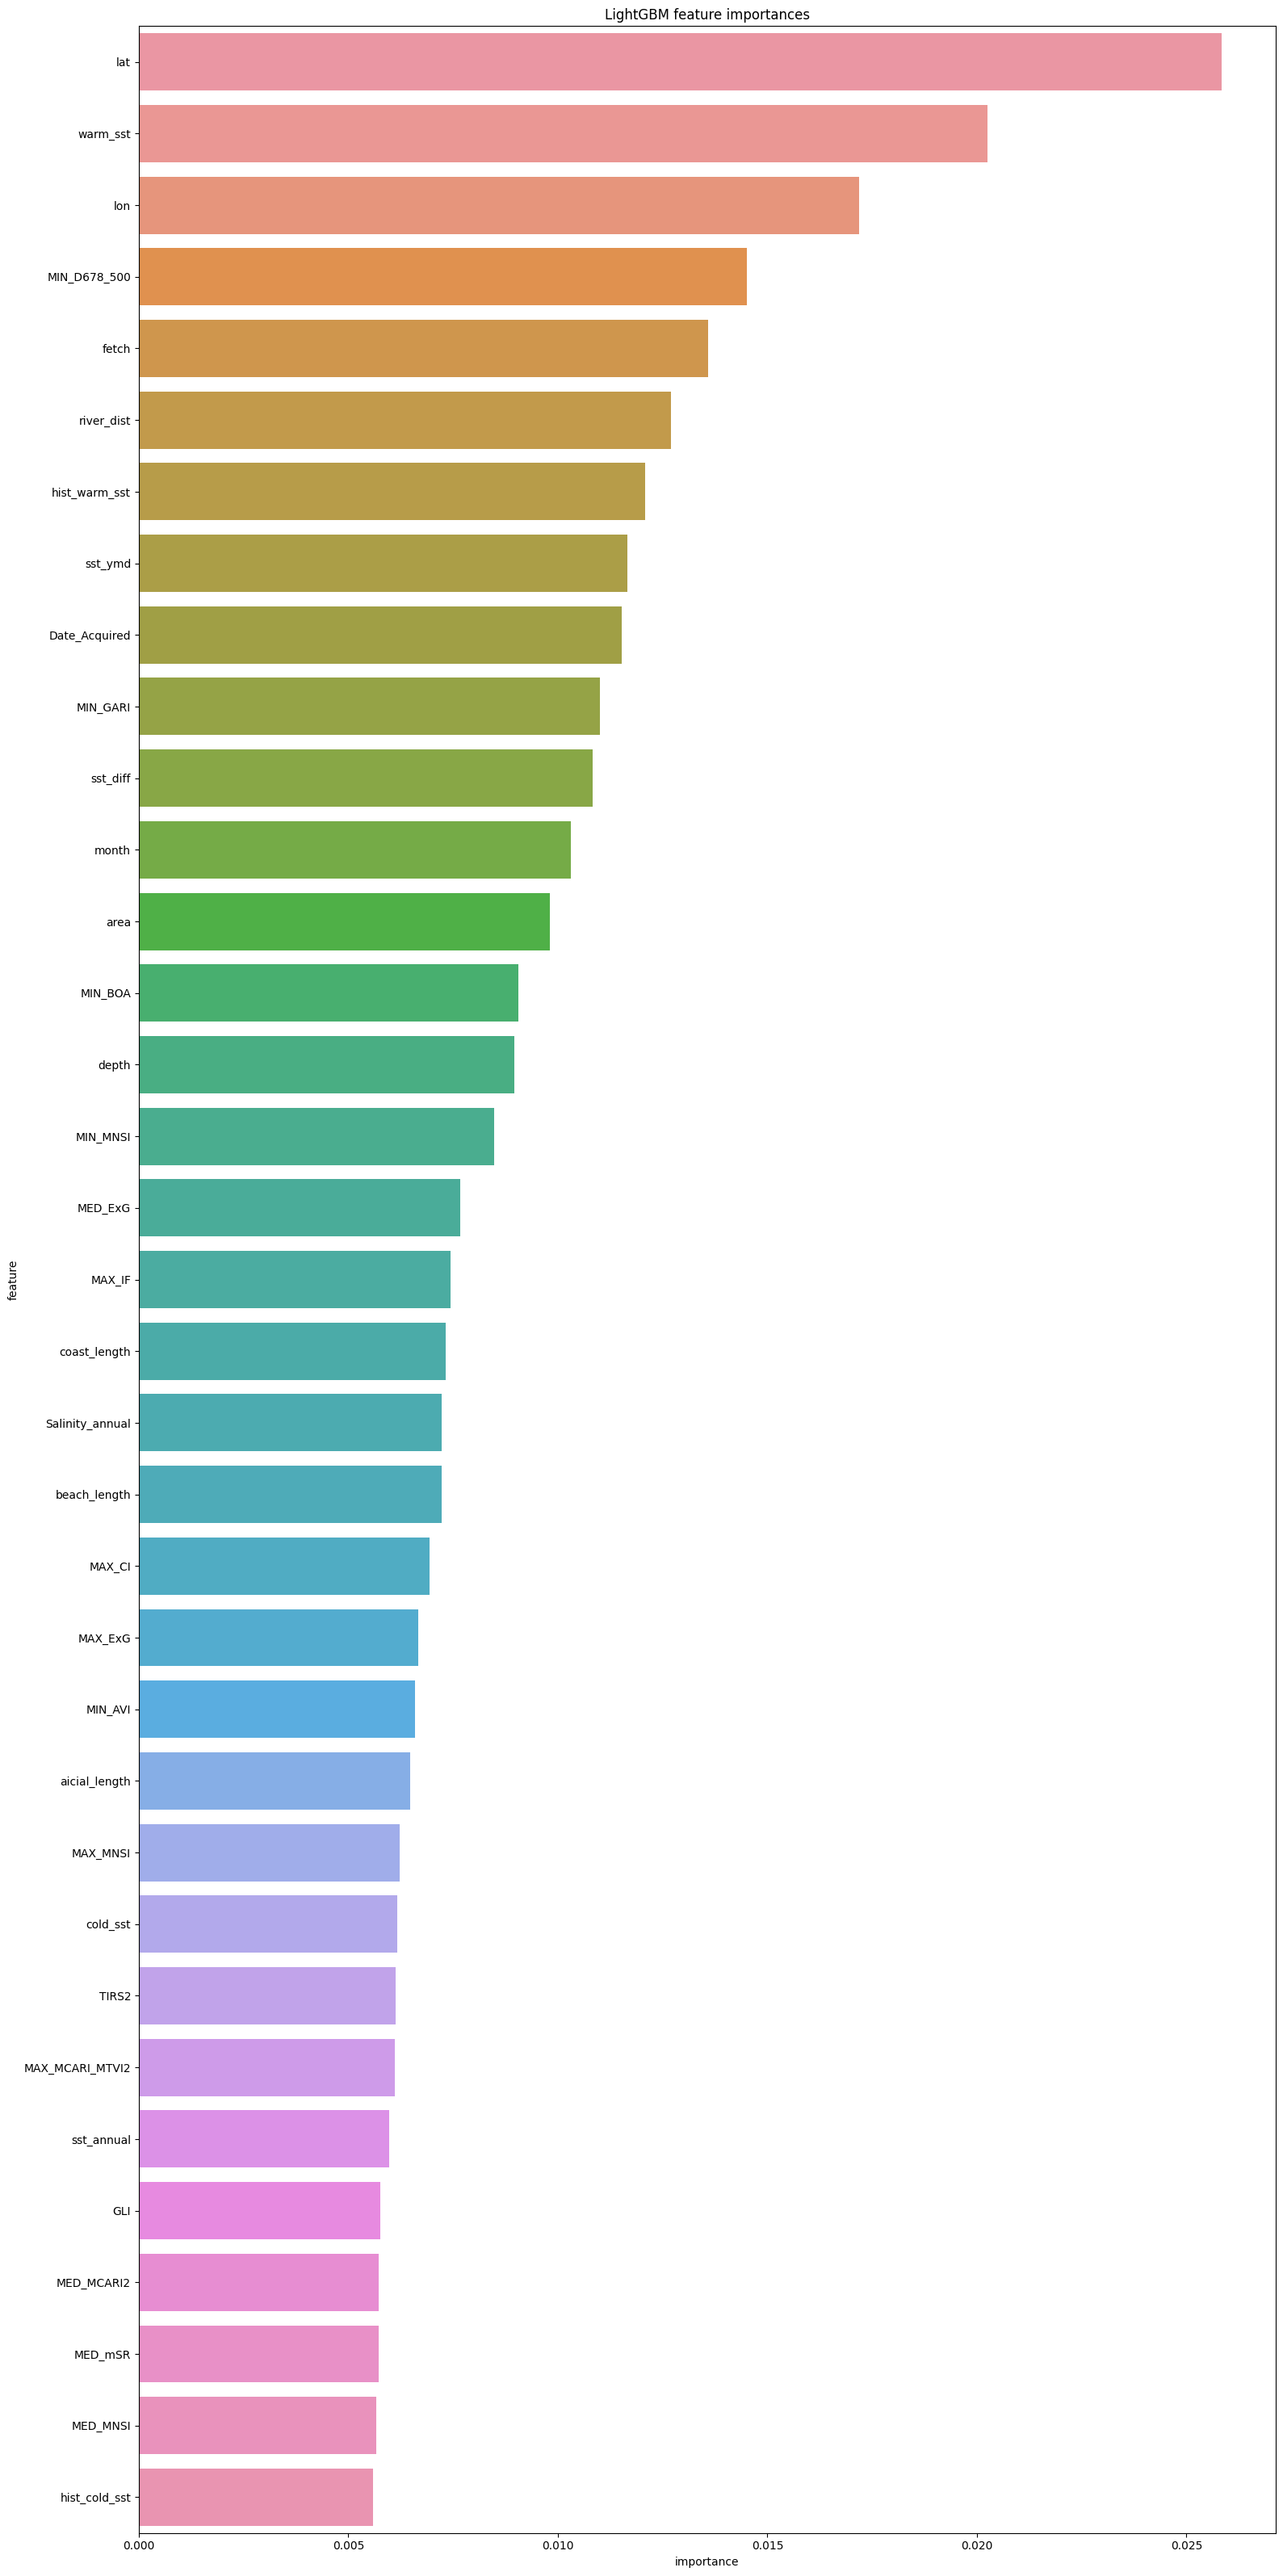

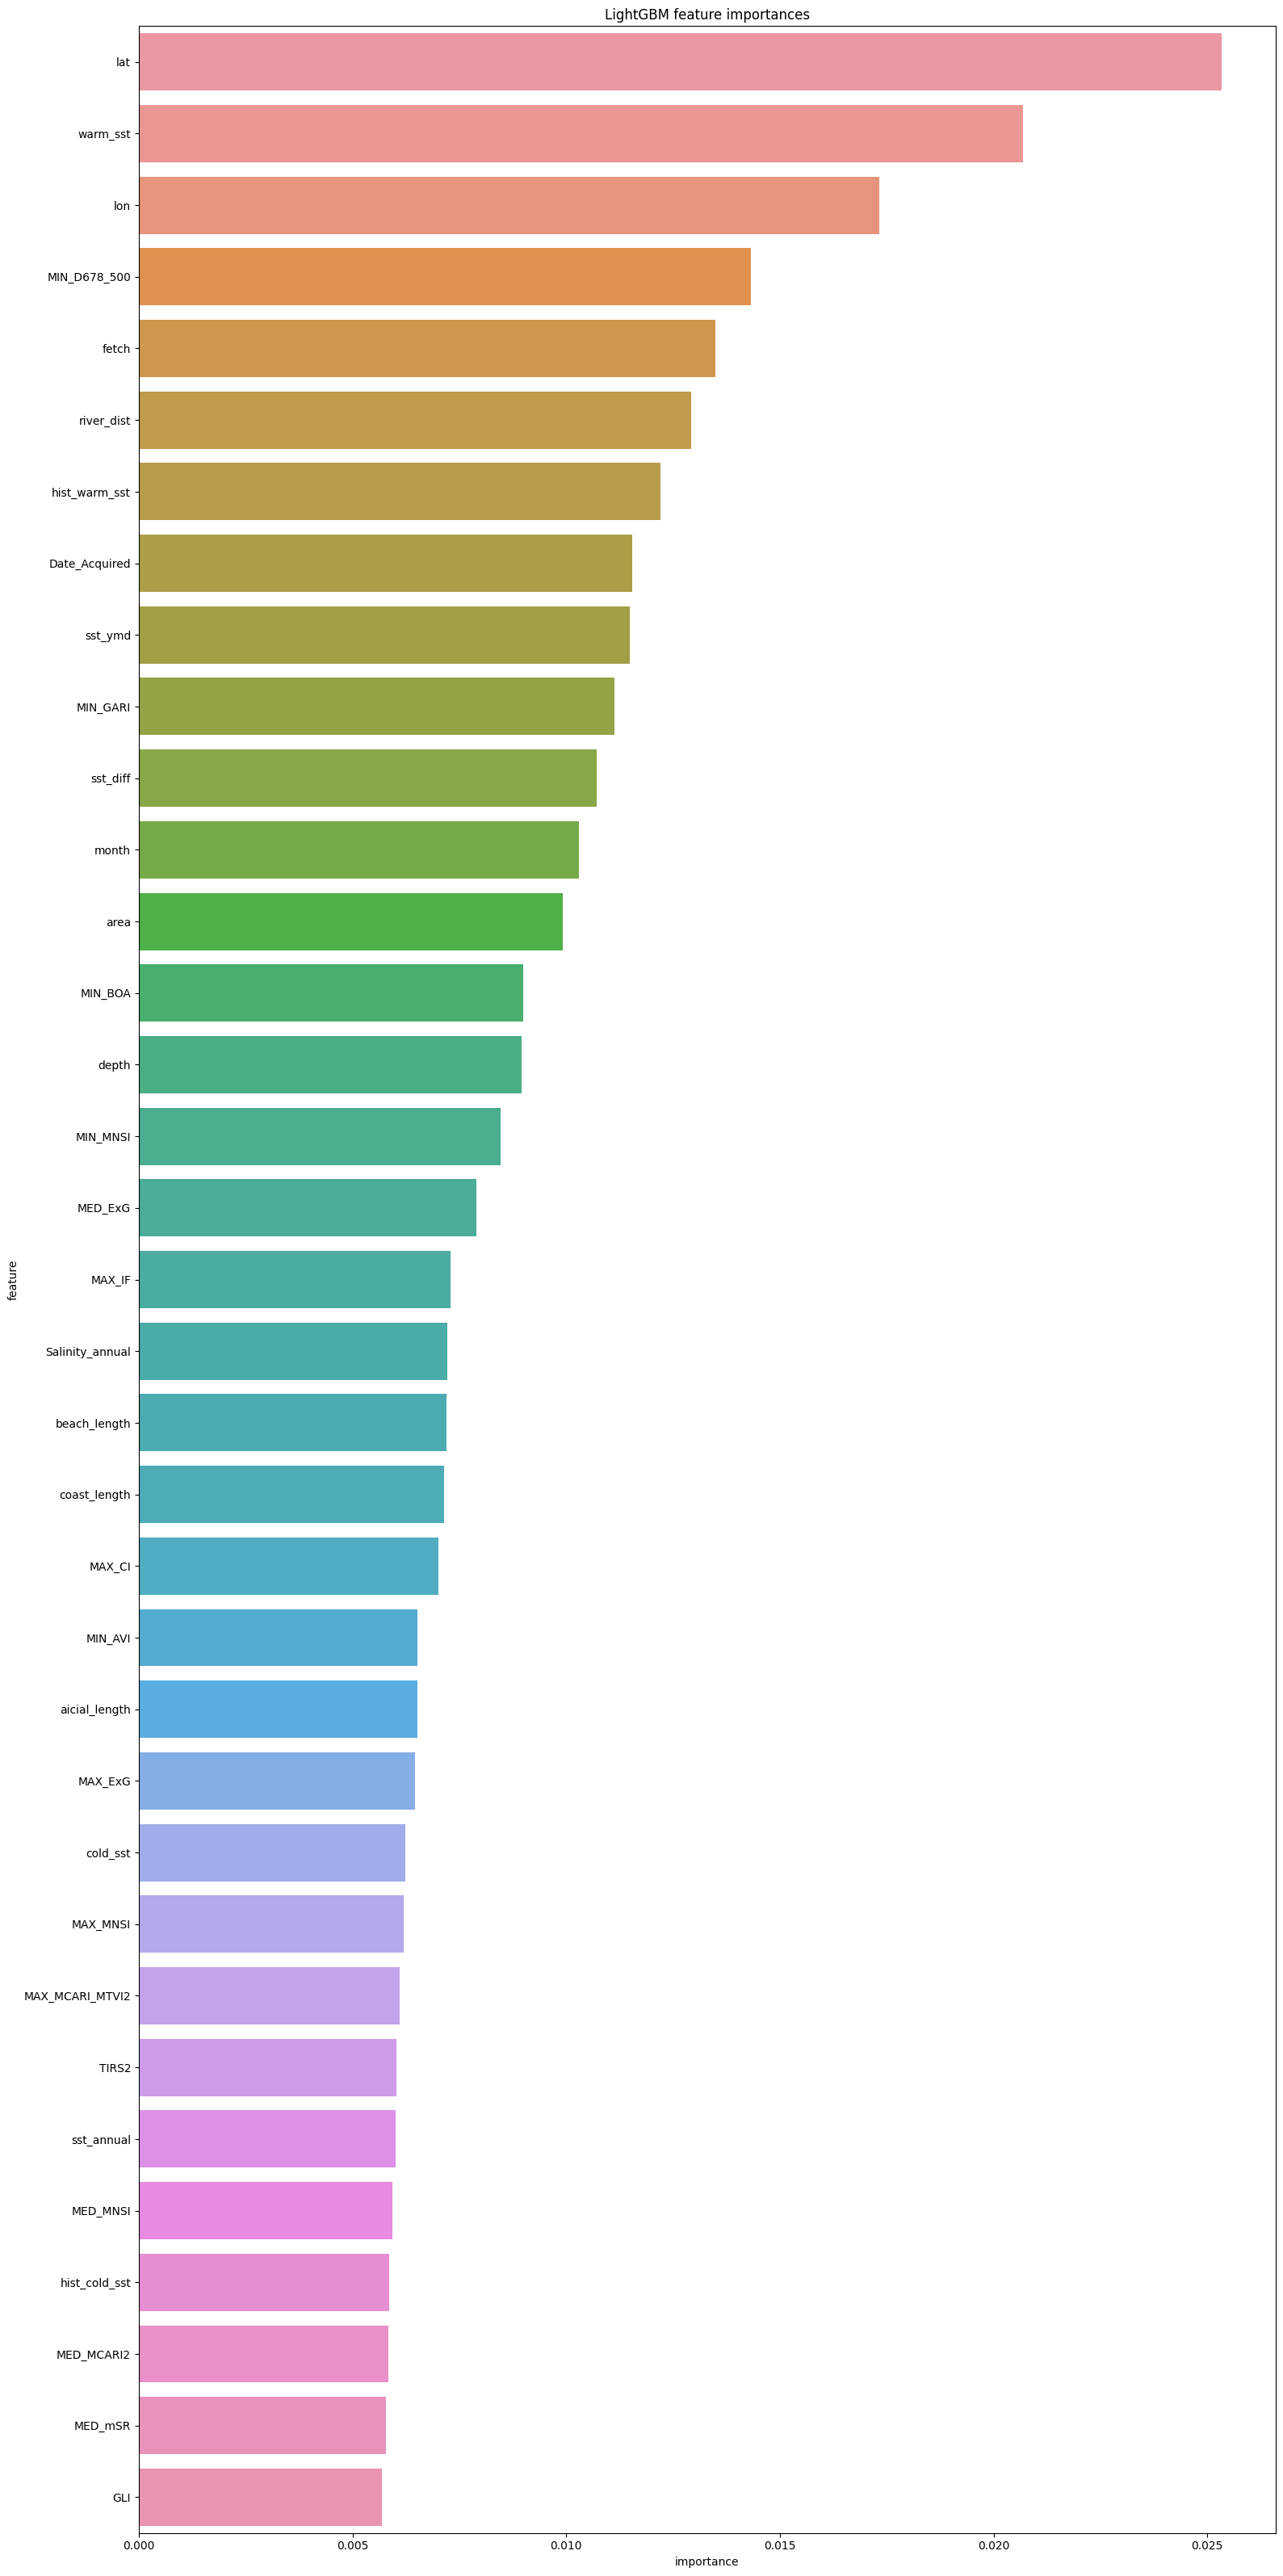

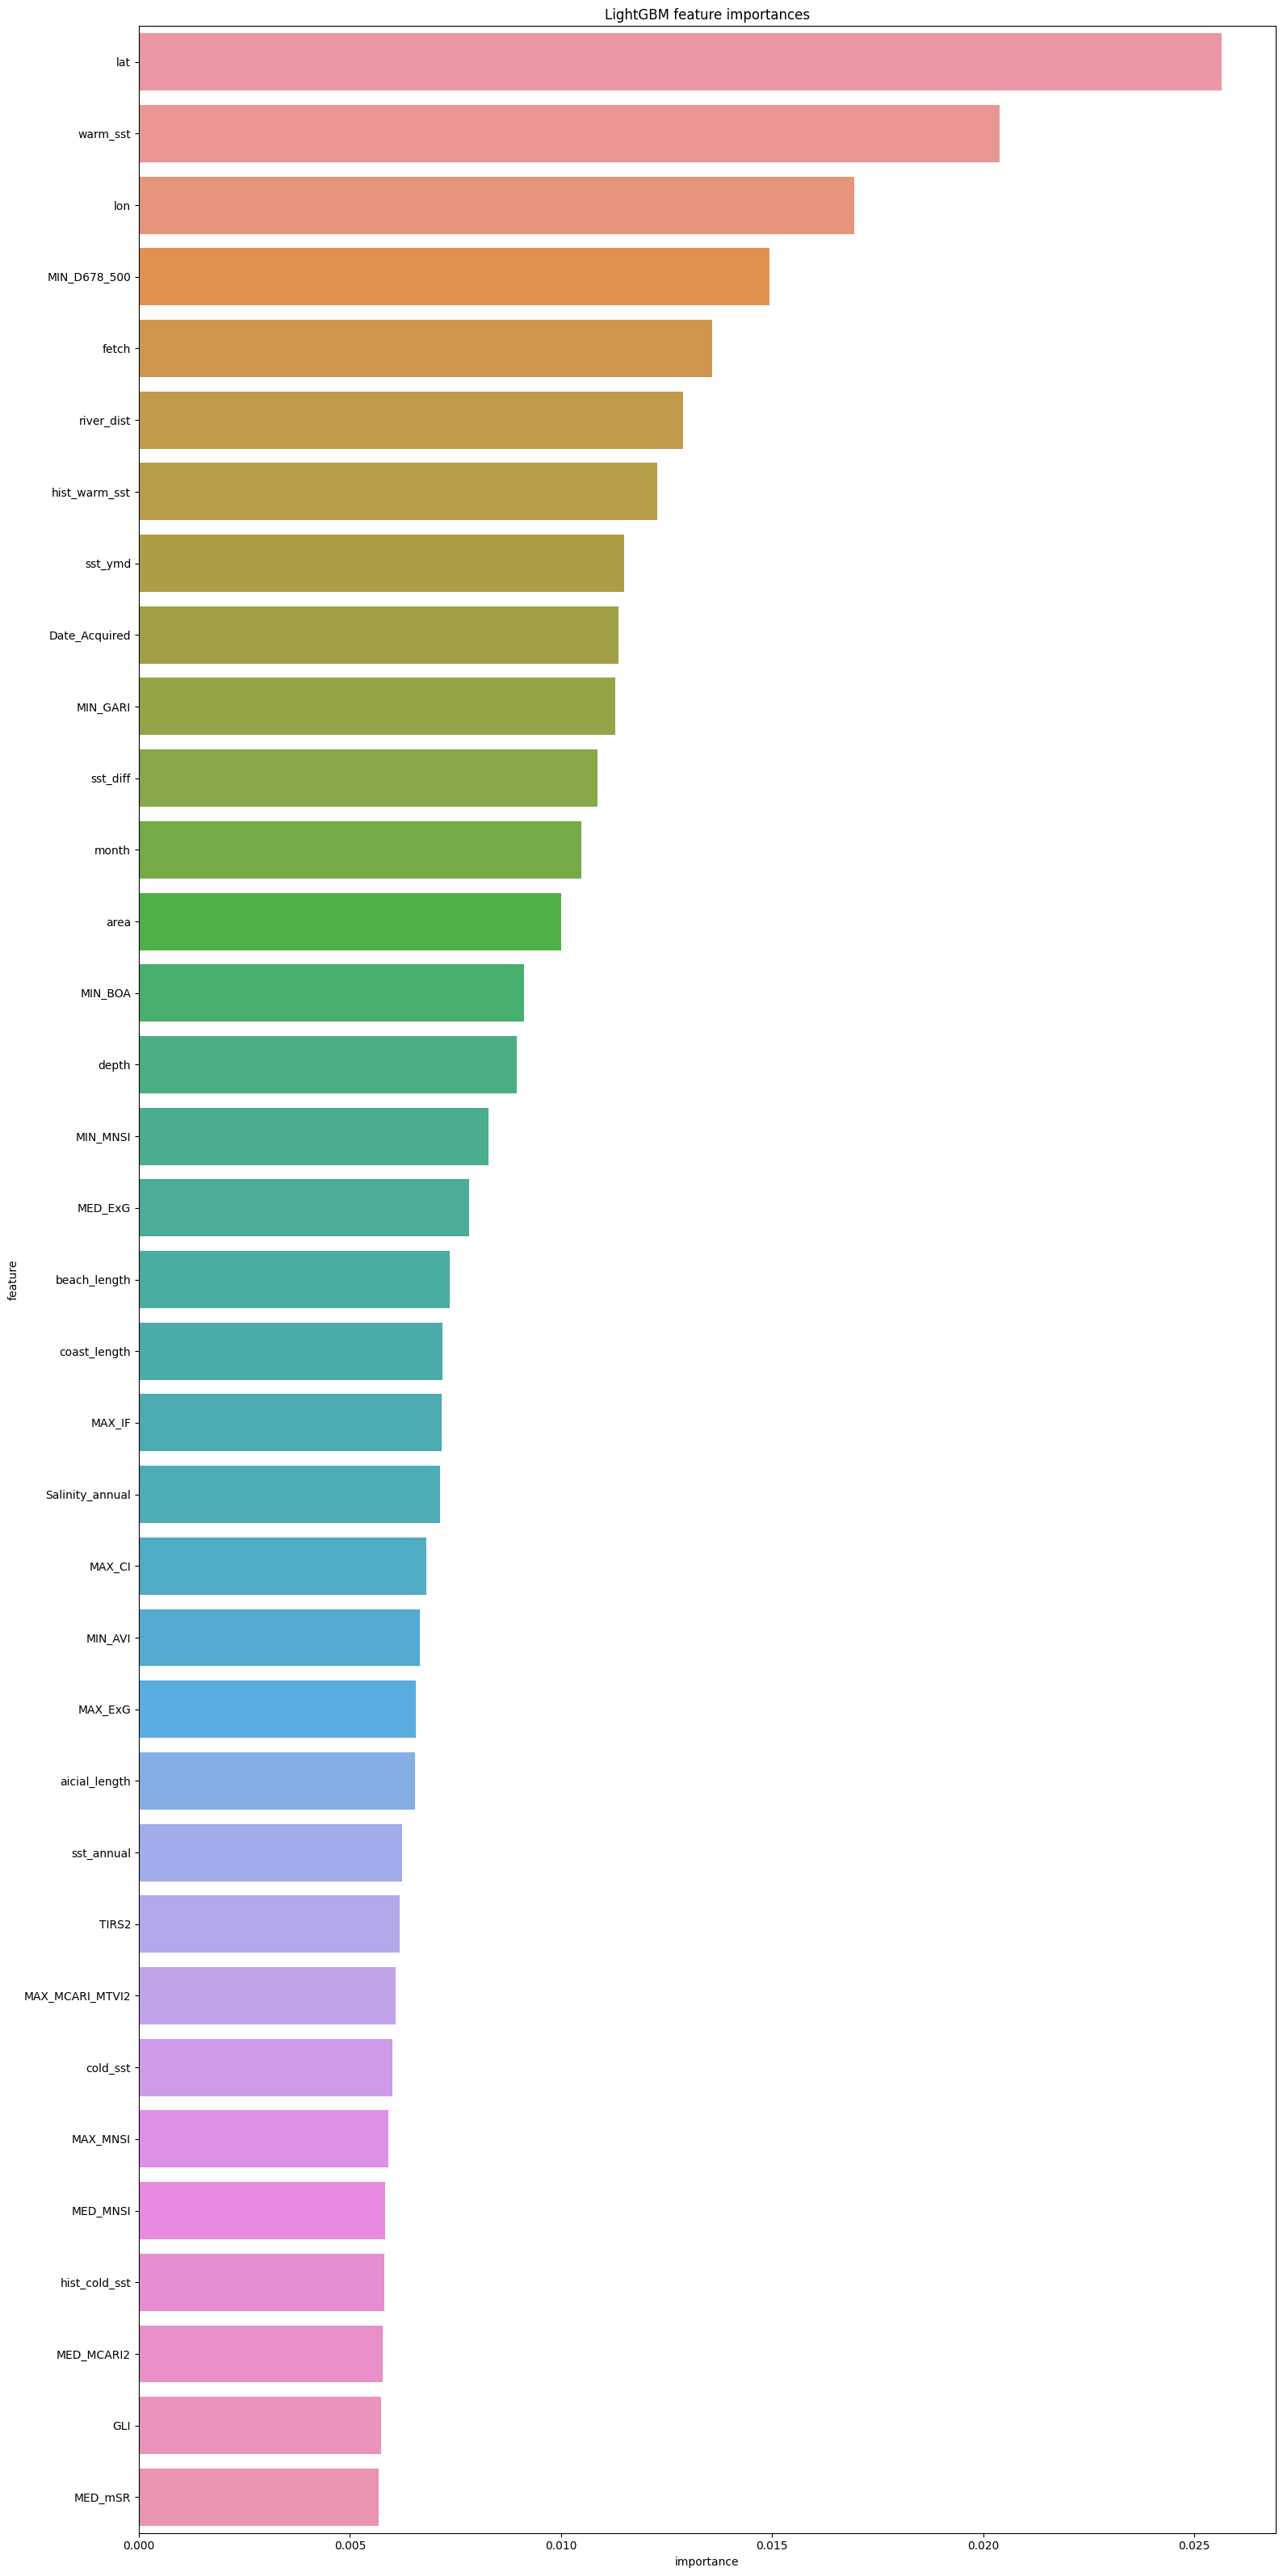

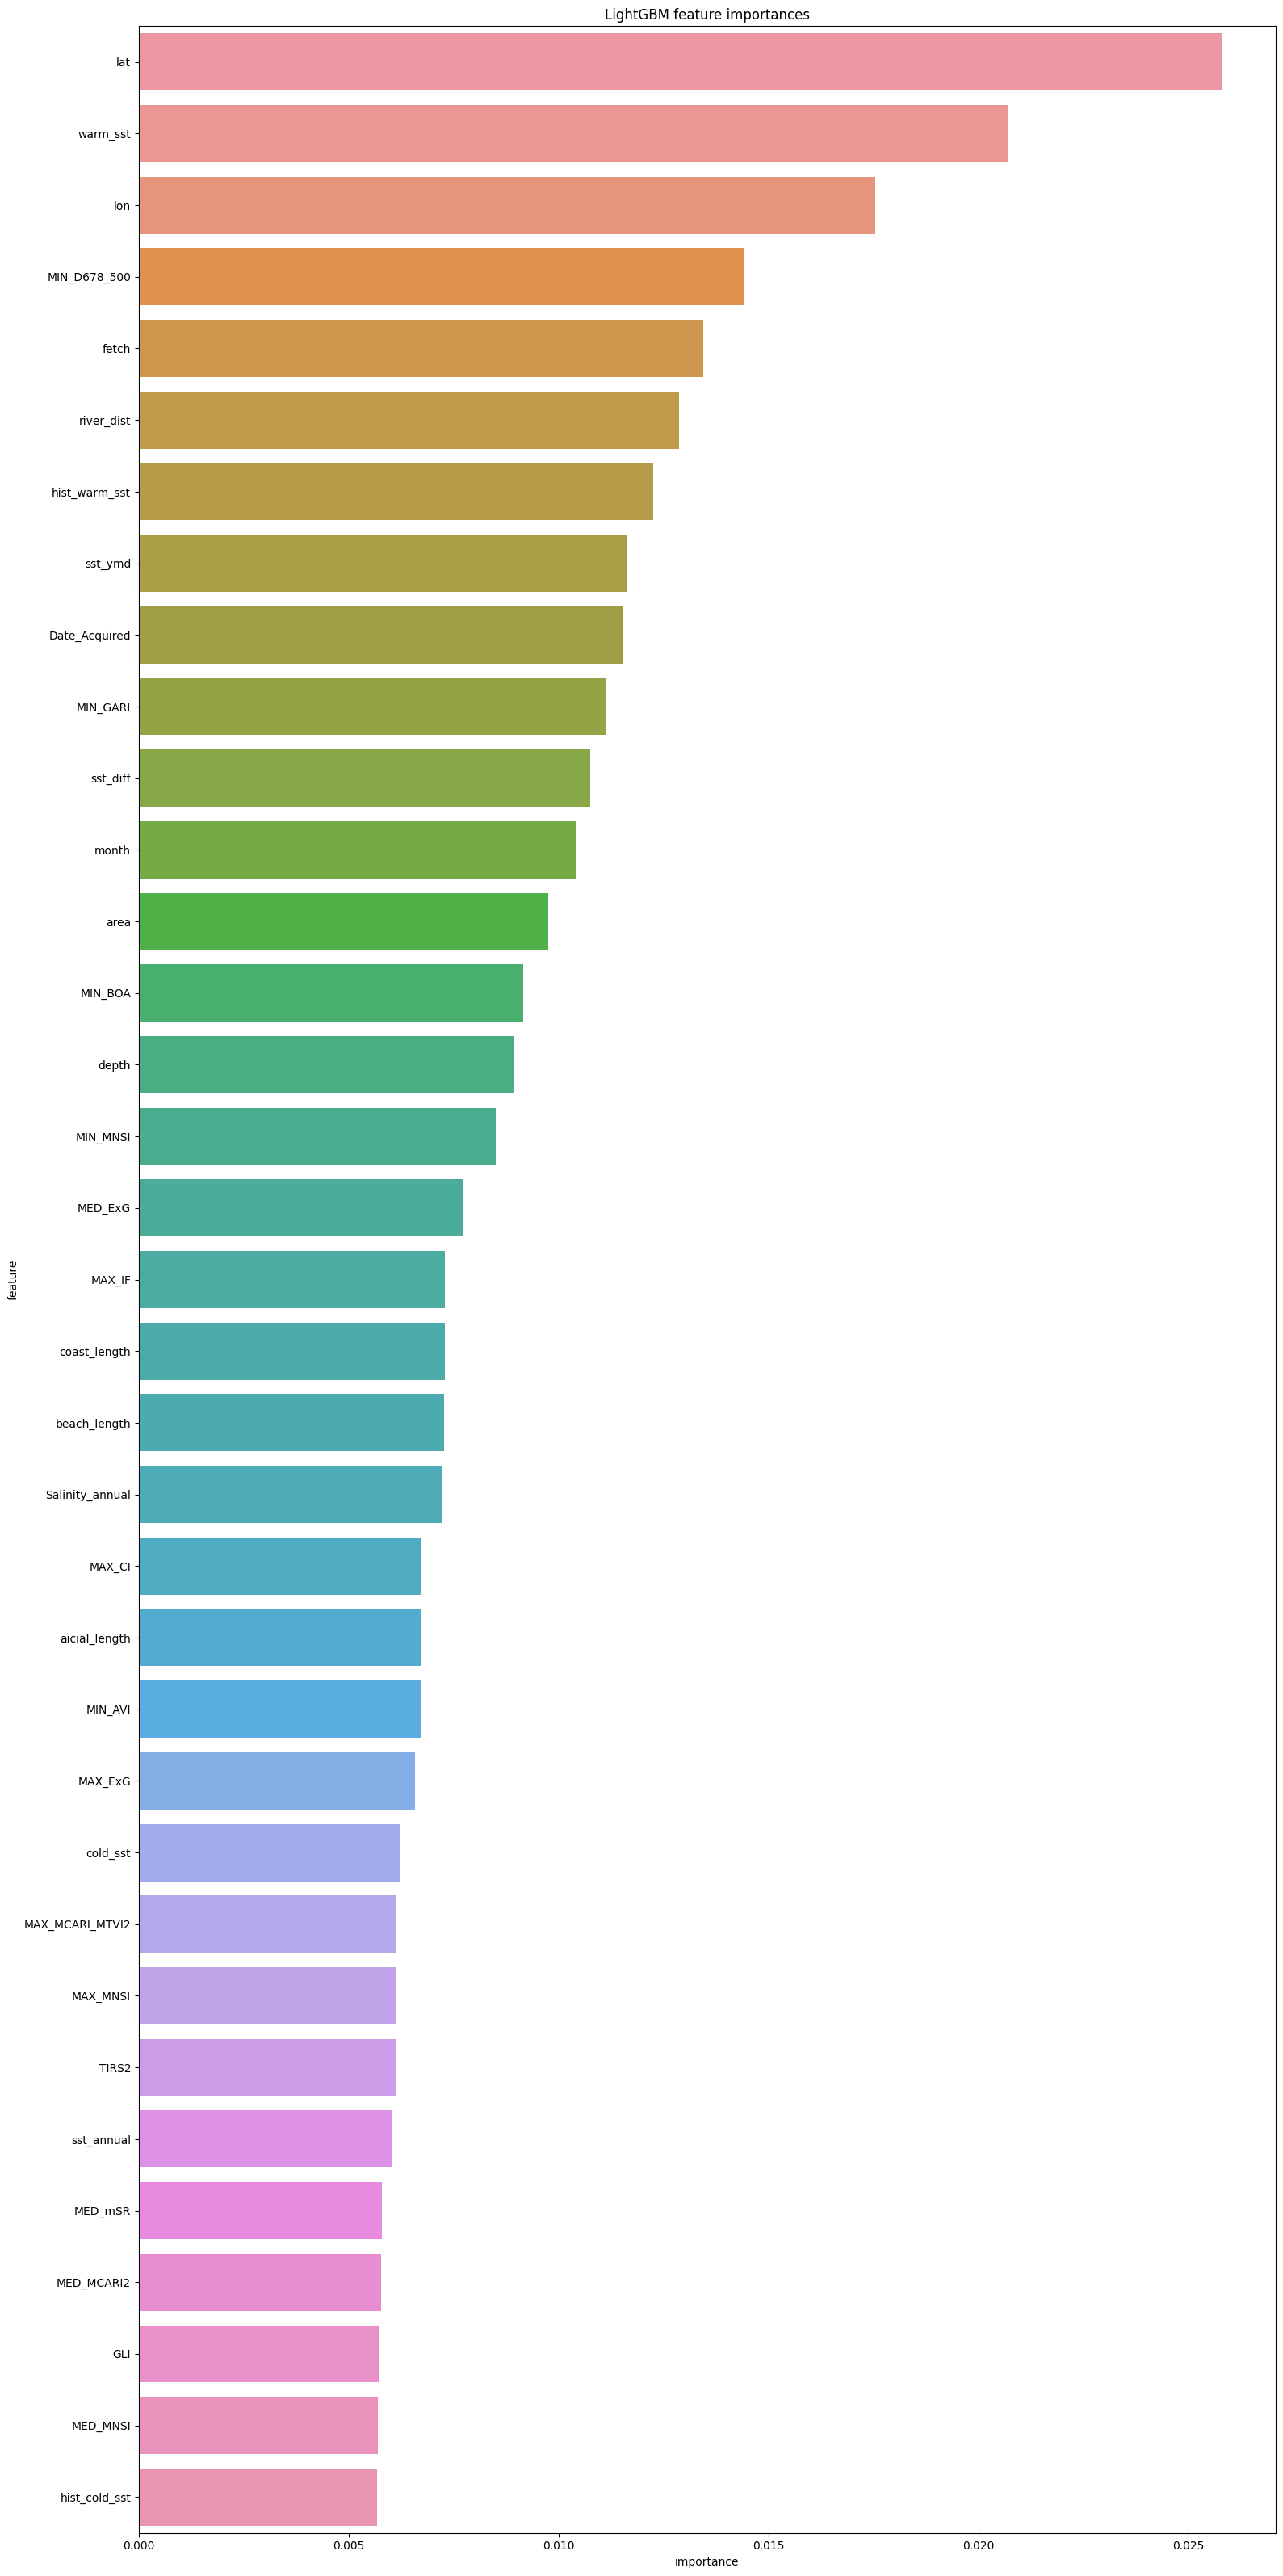

In [22]:
train['year-month'] = train.year.astype(int).astype(str) + '-' + train.month.astype(int).astype(str)
train['year-month'] = pd.to_datetime(train['year-month'], format='%Y-%m')
train = train.sort_values("year-month").reset_index(drop=True)
train = get_fold(train)
oof_preds = []
preds = np.zeros((len(test), 4))
seeds = [42, 18, 0, 2023]
for i in range(4):
  print("#"*15,f" SEED : {CFG.seed} ","#"*15)
  params["seed"] = seeds[i]
  oof_df, test_pred = get_pred(train, test, params)
  pred = np.mean(test_pred, axis=1)
  preds[:, i] = pred
  oof_preds.append(oof_df["pred"].values)
  print()

In [23]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.mean(oof_preds, axis=0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.16241302422676793


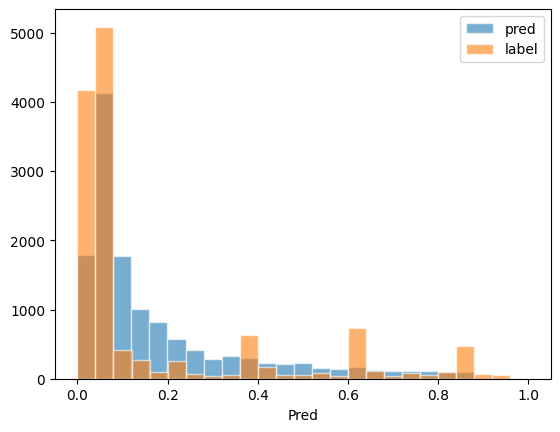

In [24]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [25]:
pred_df = test.copy()
pred_df["pred"] = np.mean(preds, axis=1)

pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_Red,knn_Chlred_edge,knn_GARI,knn_BWDRVI,knn_GEMI,knn_SWIR2,knn_MCARI2,knn_NDWI,knn_mCRIRE,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630,0.008592
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,15.177749,1.749661,-0.220478,-0.969327,-50.269846,0.203959,1.556746,0.597267,-0.418280,0.145920
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,33.772681,1.390758,-0.099560,-0.914342,-90.264924,0.365417,0.190044,0.295492,-0.316523,0.253808
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067678
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100437
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080391
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630,0.383679
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170099


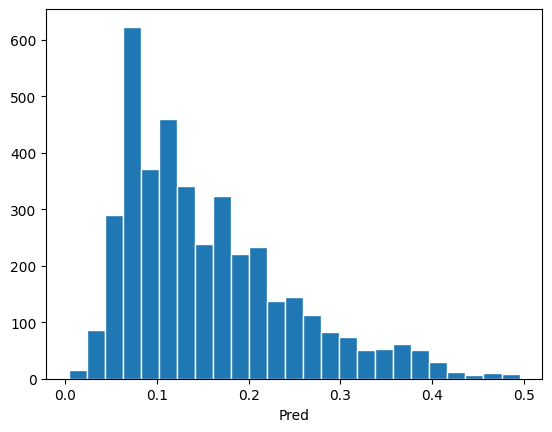

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,knn_Red,knn_Chlred_edge,knn_GARI,knn_BWDRVI,knn_GEMI,knn_SWIR2,knn_MCARI2,knn_NDWI,knn_mCRIRE,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630,0.008592
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,15.177749,1.749661,-0.220478,-0.969327,-50.269846,0.203959,1.556746,0.597267,-0.418280,0.145920
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,33.772681,1.390758,-0.099560,-0.914342,-90.264924,0.365417,0.190044,0.295492,-0.316523,0.253808
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067678
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100437
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080391
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,33.735753,1.554244,-0.077792,-0.918048,-127.003226,0.341719,0.129308,0.324695,-0.300630,0.383679
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170099


In [26]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else cover_max)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_SEEDAVERAGE_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)

In [27]:
pred_df.to_csv(os.path.join(OUTPUT_DIR, f'test_pred_LGBM_seed{CFG.seed}_ver{CFG.ver}.csv'))
_oof.to_csv(os.path.join(OUTPUT_DIR, f'OOF_LGBM_seed{CFG.seed}_ver{CFG.ver}.csv'))